Report slides: https://docs.google.com/presentation/d/1CuCeNk0ik4S4n3B8fBYy08y5c5rjRhnWK0UC4tnik-Y/edit?usp=sharing


In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### 读取数据文件

In [182]:
def read_csv_file(file_path):
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        return none
file_paths = ["user_payment_record.csv", "createrole_login_record.csv", "user_daily_session_length_record.csv"] 

df_payment = read_csv_file(file_paths[0])
df_login = read_csv_file(file_paths[1])
df_engagement = read_csv_file(file_paths[2])

In [63]:
df_payment['time'] = pd.to_datetime(df_payment['time'], unit='ms')
df_payment.head(3)

,appid,date,ctwid,server_id,time,pay_amt
0,test,2024-11-13,23dccf736f,2,2024-11-13 14:59:11.124,100
1,test,2024-11-13,2cac52ff60,3,2024-11-13 14:59:56.850,100
2,test,2024-11-13,af687842ae,43,2024-11-13 14:59:55.400,100


In [75]:
df_login['time'] = pd.to_datetime(df_login['time'], unit='ms')
df_login.head(3)

,appid,dt,ctwid,server_id,type,time
0,test,2024-11-17,84a787b8d4,44,g_login,2024-11-17 11:45:41
1,test,2024-11-17,42fa4799c1,34,g_login,2024-11-17 11:46:17
2,test,2024-11-17,96c22d3440,60,g_login,2024-11-17 11:46:19


In [73]:
df_engagement.head()

,appid,dt,ctwid,session_length
0,test,2024-11-17,a512b8cf9b,17
1,test,2024-11-17,5601d6307c,1898
2,test,2024-11-17,a0e52a52cc,1894
3,test,2024-11-17,88321a495c,1
4,test,2024-11-17,0d649666d6,6185


## Metrics per DsL

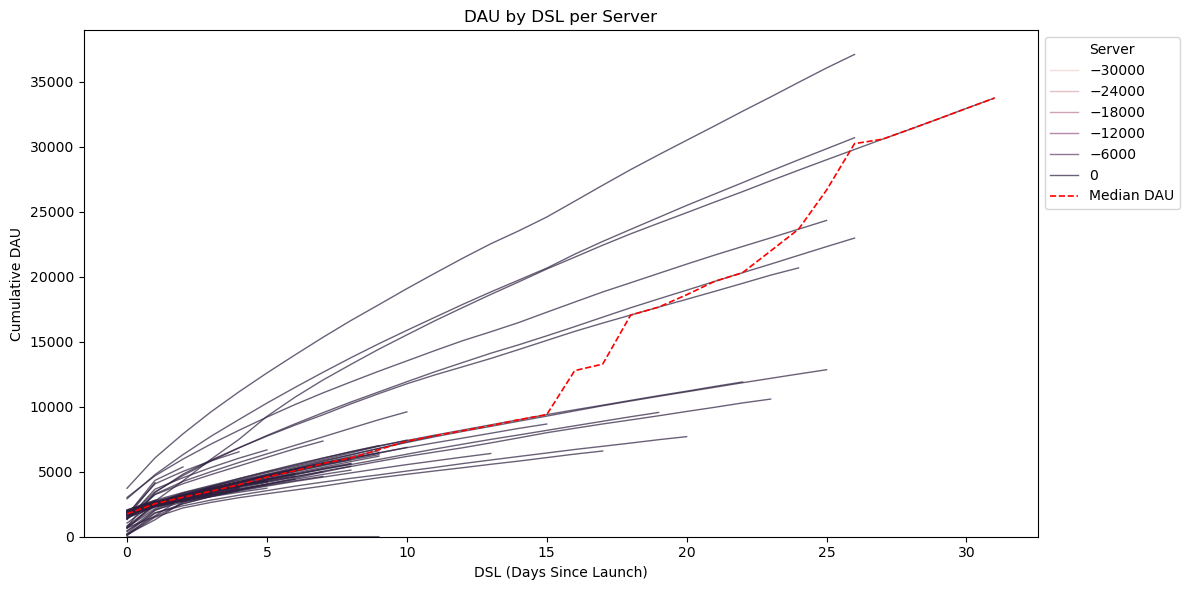

In [164]:
# DAU per DSL
df_login['dt'] = pd.to_datetime(df_login['dt'])
df_login_filtered = df_login[df_login['type'] == 'g_login']
dau_per_server = (
    df_login_filtered.groupby(['dt', 'server_id'])
    .agg(dau=('ctwid', 'nunique'))  
    .reset_index()
)
server_launch_dates = (
    dau_per_server.groupby('server_id')
    .agg(launch_date=('dt', 'min'))  
    .reset_index()
)

dau_per_server = dau_per_server.merge(server_launch_dates, on='server_id')

dau_per_server = dau_per_server.sort_values(['server_id', 'dt'])
dau_per_server['cumulative_dau'] = dau_per_server.groupby('server_id')['dau'].cumsum()
dau_per_server['dsl'] = (dau_per_server['dt'] - dau_per_server['launch_date']).dt.days

median_dpt_dau = (
    dau_per_server.groupby('dsl')
    .agg(median_dau=('cumulative_dau', 'median'))
    .reset_index()
)
median_dpt_dau['server_id'] = 'avg'

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=dau_per_server,
    x='dsl',
    y='cumulative_dau',
    hue='server_id',
    alpha=0.7,
    linewidth=1
)

sns.lineplot(
    data=median_dpt_dau,
    x='dsl',
    y='median_dau',
    color='red',
    linewidth=1.2,
    linestyle='--',
    label='Median DAU'
)

plt.xlabel("DSL (Days Since Launch)")
plt.ylabel("Cumulative DAU")
plt.title("DAU by DSL per Server")
plt.legend(title="Server", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, None)
plt.tight_layout()
plt.show()

In [180]:
df_engagement


,appid,dt,ctwid,session_length,server_id
0,test,2024-11-17,a512b8cf9b,17,NaN
1,test,2024-11-17,5601d6307c,1898,3.0
2,test,2024-11-17,a0e52a52cc,1894,64.0
3,test,2024-11-17,88321a495c,1,NaN
4,test,2024-11-17,0d649666d6,6185,33.0
...,...,...,...,...,...
2804304,test,2024-10-29,8f3fd1c742,12947,1.0
2804305,test,2024-10-29,3a6d1ab888,316,3.0
2804306,test,2024-10-29,a7659fd0d9,5295,5.0
2804307,test,2024-10-29,538844702d,601,9.0


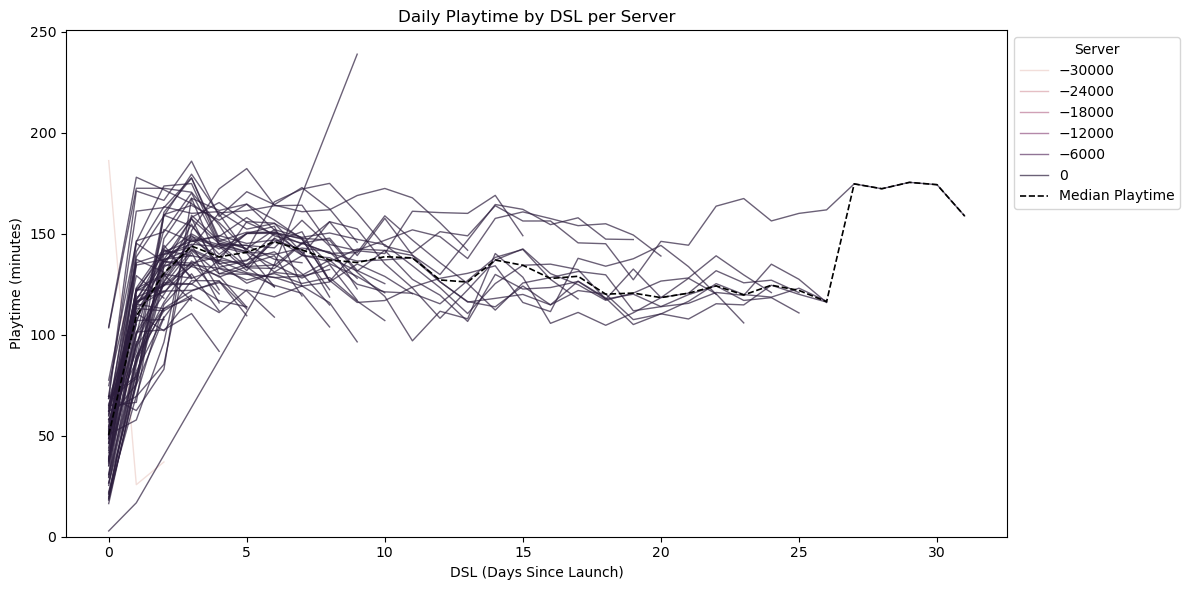

In [190]:
# Session Length
dt_user = (
    df_login[df_login['type'] == 'g_login']
    [['ctwid', 'server_id']]
    .drop_duplicates()
)

dt_engagement_agg = df_engagement.merge(dt_user, on='ctwid', how='left')
dt_engagement_agg = dt_engagement_agg[dt_engagement_agg['server_id'].notna()]

dt_engagement_agg['dt'] = pd.to_datetime(dt_engagement_agg['dt'])

dt_dailyplaytime = (
    dt_engagement_agg.groupby(['dt', 'ctwid', 'server_id'])
    .agg(session_time=('session_length', 'sum'))
    .reset_index()
    .groupby(['dt', 'server_id'])
    .agg(session_length_avg=('session_time', 'mean'))
    .reset_index()
)
dt_dailyplaytime['session_length_avg'] /= 60 

server_launch_date = dau_per_server[['server_id', 'launch_date']].drop_duplicates()

dt_dailyplaytime_plot = dt_dailyplaytime.merge(server_launch_date, on='server_id', how='left')
dt_dailyplaytime_plot['dsl'] = (dt_dailyplaytime_plot['dt'] - dt_dailyplaytime_plot['launch_date']).dt.days
dt_dailyplaytime_plot = dt_dailyplaytime_plot[dt_dailyplaytime_plot['dsl'] >= 0]
dt_dailyplaytime_plot = dt_dailyplaytime_plot[dt_dailyplaytime_plot['session_length_avg'] < 300]

median_dpt = (
    dt_dailyplaytime_plot.groupby('dsl')
    .agg(median_dpt=('session_length_avg', 'median'))
    .reset_index()
)
median_dpt['server_id'] = 'avg'

plt.figure(figsize=(12, 6))

# 每个服务器的每日游玩时长曲线
sns.lineplot(
    data=dt_dailyplaytime_plot,
    x='dsl',
    y='session_length_avg',
    hue='server_id',
    alpha=0.7,
    linewidth=1
)

# 中位数每日游玩时长曲线
sns.lineplot(
    data=median_dpt,
    x='dsl',
    y='median_dpt',
    color='black',
    linewidth=1.2,
    linestyle='--',
    label='Median Playtime'
)

plt.xlabel("DSL (Days Since Launch)")
plt.ylabel("Playtime (minutes)")
plt.title("Daily Playtime by DSL per Server")
plt.legend(title="Server", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, None)
plt.tight_layout()
plt.show()

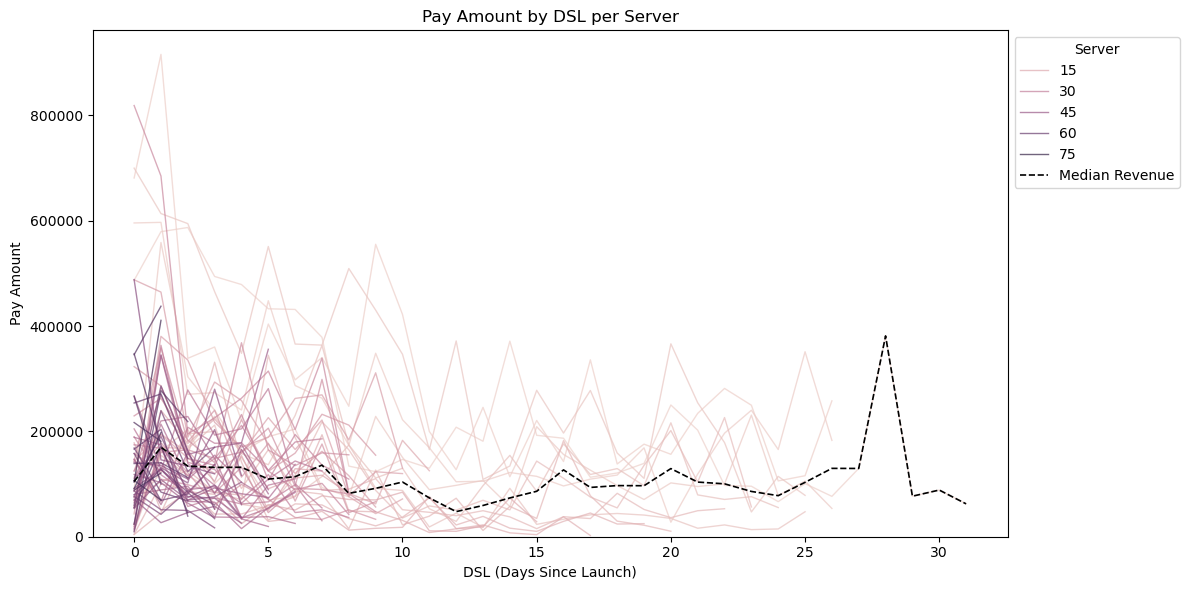

In [195]:
# Pay Amount & ARPU

df_payment['date'] = pd.to_datetime(df_payment['date'])

dt_payment_agg = (
    df_payment.groupby(['date', 'server_id'])
    .agg(revenue=('pay_amt', 'sum'), paidau=('ctwid', 'nunique'))
    .reset_index()
)

dt_payment_agg = dt_payment_agg.merge(server_launch_date, on='server_id', how='left')
dt_payment_agg['dsl'] = (dt_payment_agg['date'] - dt_payment_agg['launch_date']).dt.days
dt_payment_agg = dt_payment_agg[dt_payment_agg['dsl'] >= 0]


median_revenue = (
    dt_payment_agg.groupby('dsl')
    .agg(median_revenue=('revenue', 'median'))
    .reset_index()
)
median_revenue['server_id'] = 'avg'

plt.figure(figsize=(12, 6))

# 每个服务器的支付金额曲线
sns.lineplot(
    data=dt_payment_agg,
    x='dsl',
    y='revenue',
    hue='server_id',
    alpha=0.7,
    linewidth=1
)

# 中位数支付金额曲线
sns.lineplot(
    data=median_revenue,
    x='dsl',
    y='median_revenue',
    color='black',
    linewidth=1.2,
    linestyle='--',
    label='Median Revenue'
)

plt.xlabel("DSL (Days Since Launch)")
plt.ylabel("Pay Amount")
plt.title("Pay Amount by DSL per Server")
plt.legend(title="Server", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, None)
plt.tight_layout()
plt.show()

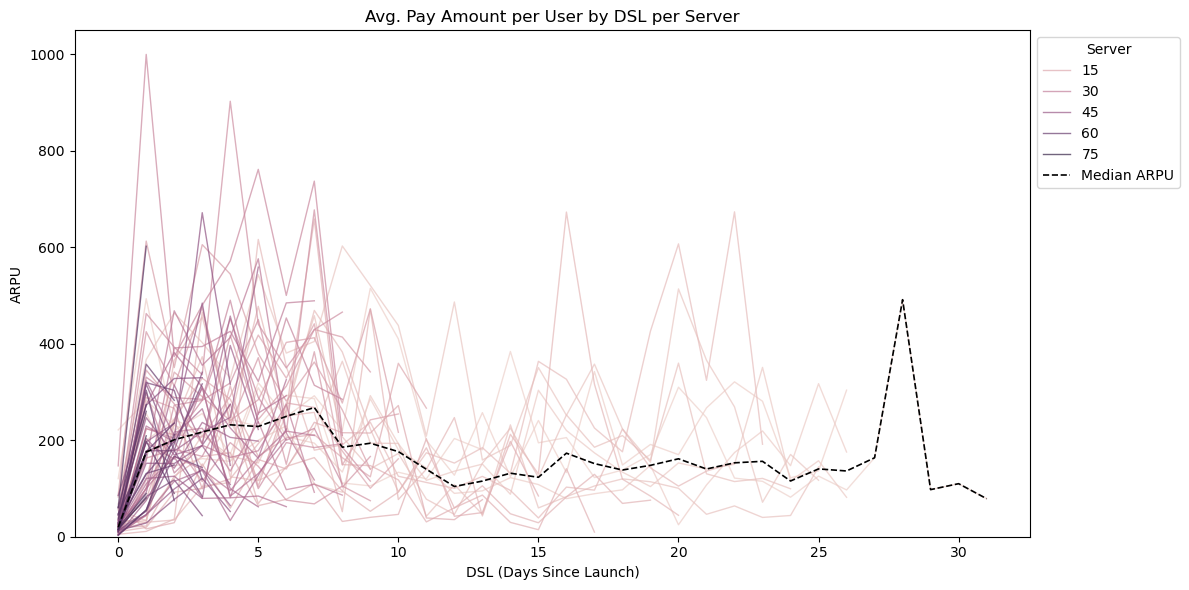

In [207]:
dt_dau_per_server = (
    df_login.groupby(['dt', 'server_id'])
    .agg(dau=('ctwid', 'nunique'))
    .reset_index()
)

dt_dau_per_server.rename(columns={'dt': 'date'}, inplace=True)

dt_dau_per_server['date'] = pd.to_datetime(dt_dau_per_server['date'])
dt_payment_agg['date'] = pd.to_datetime(dt_payment_agg['date'])


dt_payment_agg = dt_payment_agg.merge(dt_dau_per_server, on=['date', 'server_id'], how='left')
dt_payment_agg['arpu'] = dt_payment_agg['revenue'] / dt_payment_agg['dau']

median_arpu = (
    dt_payment_agg.groupby('dsl')
    .agg(median_arpu=('arpu', 'median'))
    .reset_index()
)
median_arpu['server_id'] = 'avg'

plt.figure(figsize=(12, 6))

# 每个服务器的 ARPU 曲线
sns.lineplot(
    data=dt_payment_agg,
    x='dsl',
    y='arpu',
    hue='server_id',
    alpha=0.7,
    linewidth=1
)

# 中位数 ARPU 曲线
sns.lineplot(
    data=median_arpu,
    x='dsl',
    y='median_arpu',
    color='black',
    linewidth=1.2,
    linestyle='--',
    label='Median ARPU'
)

plt.xlabel("DSL (Days Since Launch)")
plt.ylabel("ARPU")
plt.title("Avg. Pay Amount per User by DSL per Server")
plt.legend(title="Server", loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, None)
plt.tight_layout()
plt.show()

## Score system

In [231]:
# Retention for AU
first_login = (
    df_login.groupby(['server_id', 'ctwid'])
    .agg(first_login_date=('dt', 'min'))
    .reset_index()
)

dt_with_first_login = df_login.merge(first_login, on=['server_id', 'ctwid'], how='inner')

dt_with_first_login['dt'] = pd.to_datetime(dt_with_first_login['dt'])
dt_with_first_login['first_login_date'] = pd.to_datetime(dt_with_first_login['first_login_date'])


retention_rates = (
    dt_with_first_login.assign(
        days_since_first_login=(dt_with_first_login['dt'] - dt_with_first_login['first_login_date']).dt.days
    )
    .query("days_since_first_login in [0, 1, 3, 7]")
    .groupby(['dt', 'server_id', 'first_login_date', 'days_since_first_login'])
    .agg(active_users=('ctwid', 'nunique'))
    .reset_index()
)

retention_rates = (
    retention_rates.groupby(['server_id', 'first_login_date'])
    .apply(lambda group: group.assign(
        retention_rate=group['active_users'] / group.loc[group['days_since_first_login'] == 0, 'active_users'].iloc[0]
    ))
    .reset_index(drop=True)
)

retention_rates = retention_rates[retention_rates['days_since_first_login'] != 0]

/var/folders/s6/8dm8rktd6wj31t8j91_0g7b40000gn/T/ipykernel_3312/421787131.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [235]:
# Retention for Paid AU
filtered_dt_login = df_login[df_login['ctwid'].isin(df_payment['ctwid'])]

first_login = (
    filtered_dt_login.groupby(['server_id', 'ctwid'])
    .agg(first_login_date=('dt', 'min'))
    .reset_index()
)

dt_with_first_login = df_login.merge(first_login, on=['server_id', 'ctwid'], how='inner')
dt_with_first_login['dt'] = pd.to_datetime(dt_with_first_login['dt'])
dt_with_first_login['first_login_date'] = pd.to_datetime(dt_with_first_login['first_login_date'])

retention_rates_pau = (
    dt_with_first_login.assign(
        days_since_first_login=(dt_with_first_login['dt'] - dt_with_first_login['first_login_date']).dt.days
    )
    .query("days_since_first_login in [0, 1, 3, 7]")
    .groupby(['dt', 'server_id', 'first_login_date', 'days_since_first_login'])
    .agg(active_users=('ctwid', 'nunique'))
    .reset_index()
)

retention_rates_pau = (
    retention_rates_pau.groupby(['server_id', 'first_login_date'])
    .apply(lambda group: group.assign(
        retention_rate=group['active_users'] / group.loc[group['days_since_first_login'] == 0, 'active_users'].iloc[0]
    ))
    .reset_index(drop=True)
)

retention_rates_pau = retention_rates_pau[retention_rates_pau['days_since_first_login'] != 0]

/var/folders/s6/8dm8rktd6wj31t8j91_0g7b40000gn/T/ipykernel_3312/3566185089.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [241]:
# Score Calculation
import pandas as pd

# 筛选 dsl < 3 的数据，并计算各服务器的平均 revenue 和 arpu
dt_score = (
    dt_payment_agg[dt_payment_agg['dsl'] < 3]
    .groupby('server_id')
    .agg(revenue=('revenue', 'mean'), arpu=('arpu', 'mean'))
    .reset_index()
)

# 计算 paidau/dau 的平均值并合并到 dt_score
pau_perc = (
    dt_payment_agg[dt_payment_agg['dsl'] < 3]
    .assign(pau_perc=lambda x: x['paidau'] / x['dau'])
    .groupby('server_id')
    .agg(pau_perc=('pau_perc', 'mean'))
    .reset_index()
)
dt_score = dt_score.merge(pau_perc, on='server_id', how='left')

# 计算 retention_1 并合并到 dt_score
retention_1 = (
    retention_rates.merge(server_launch_date, on='server_id')
    .assign(dsl=lambda x: (pd.to_datetime(x['dt']) - pd.to_datetime(x['launch_date'])).dt.days)
    .query("dsl <= 3 & days_since_first_login == 1")
    .groupby('server_id')
    .agg(retention_1=('retention_rate', 'mean'))
    .reset_index()
)
dt_score = dt_score.merge(retention_1, on='server_id', how='left')

# 计算 retention_1_pau 并合并到 dt_score
retention_1_pau = (
    retention_rates_pau.merge(server_launch_date, on='server_id')
    .assign(dsl=lambda x: (pd.to_datetime(x['dt']) - pd.to_datetime(x['launch_date'])).dt.days)
    .query("dsl <= 3 & days_since_first_login == 3")
    .groupby('server_id')
    .agg(retention_1_pau=('retention_rate', 'mean'))
    .reset_index()
)
dt_score = dt_score.merge(retention_1_pau, on='server_id', how='left')

# 定义标准化函数
def normalize(x):
    return (x - x.min(skipna=True)) / (x.max(skipna=True) - x.min(skipna=True))

# 对除 server_id 外的列进行标准化
dt_score_normalized = dt_score.copy()
for col in dt_score.columns[1:]:
    dt_score_normalized[f'{col}_normalized'] = normalize(dt_score[col])

# 计算总分数 totalscore
dt_score_normalized['totalscore'] = (
    0.4 * dt_score_normalized['revenue_normalized'] +
    0.2 * dt_score_normalized['arpu_normalized'] +
    0.2 * dt_score_normalized['pau_perc_normalized'] +
    0.1 * dt_score_normalized['retention_1_normalized'] +
    0.1 * dt_score_normalized['retention_1_pau_normalized']
)

# 按 totalscore 排序
ranked_scores = dt_score_normalized[['server_id', 'totalscore']].sort_values(by='totalscore', ascending=False)

# 计算指定服务器的均值
selected_servers = dt_score[dt_score['server_id'].isin([1, 2, 5, 26])].mean(numeric_only=True)

# 打印结果
print(ranked_scores)
print(selected_servers)

    server_id  totalscore
1           2    0.836386
0           1    0.808481
4           5    0.717321
25         26    0.698649
2           3    0.594754
..        ...         ...
73         74         NaN
74         75         NaN
75         76         NaN
76         77         NaN
77         78         NaN

[78 rows x 2 columns]
server_id               8.500000
revenue            599548.583333
arpu                  333.267263
pau_perc                0.093813
retention_1             0.263930
retention_1_pau         0.606103
dtype: float64


## Breaking point

<Figure size 1200x800 with 0 Axes>

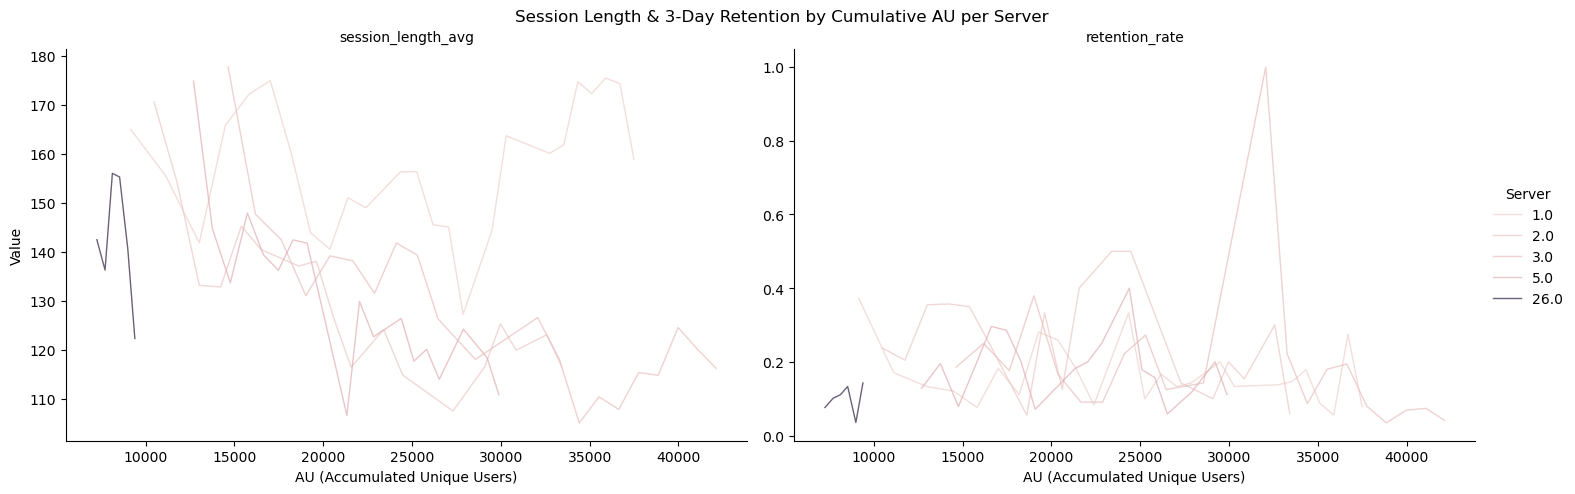

In [248]:
# 计算累计去重用户数
cumulative_unique_users = (
    df_login.groupby(['server_id', 'dt'])
    .agg(unique_users=('ctwid', 'nunique'))
    .reset_index()
    .sort_values(['server_id', 'dt'])
    .assign(cumulative_unique_users=lambda x: x.groupby('server_id')['unique_users'].cumsum())
)

dt_bp_dpt = dt_dailyplaytime_plot[['dt', 'server_id', 'session_length_avg']]
dt_bp_ret = retention_rates[retention_rates['days_since_first_login'] == 3][['dt', 'server_id', 'retention_rate']]

dt_bp_ret['dt'] = pd.to_datetime(dt_bp_ret['dt'])
cumulative_unique_users['dt'] = pd.to_datetime(cumulative_unique_users['dt'])


dt_bp = (
    dt_bp_dpt.merge(dt_bp_ret, on=['dt', 'server_id'], how='left')
    .merge(cumulative_unique_users, on=['server_id', 'dt'], how='left')
    .dropna(subset=['retention_rate'])
)

# 筛选指定服务器
filtered_dt_bp = dt_bp[dt_bp['server_id'].isin([1, 2, 26, 5, 3])]

dt_bp_long = filtered_dt_bp.melt(
    id_vars=['server_id', 'dt', 'cumulative_unique_users'],
    value_vars=['session_length_avg', 'retention_rate'],
    var_name='metric',
    value_name='value'
)

plt.figure(figsize=(12, 8))
g = sns.FacetGrid(dt_bp_long, col='metric', sharey=False, sharex=False, height=5, aspect=1.5)
g.map_dataframe(
    sns.lineplot, x='cumulative_unique_users', y='value', hue='server_id', alpha=0.7, linewidth=1
)

g.set_axis_labels("AU (Accumulated Unique Users)", "Value")
g.set_titles("{col_name}")
g.add_legend(title="Server")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Session Length & 3-Day Retention by Cumulative AU per Server")
plt.show()